<a href="https://colab.research.google.com/github/noorasmat/Pytorch-for-CNN-using-CUDA-and-Google-Drive/blob/master/cnn_with_pytorch_using_Cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN with PyTorch and Cuda

1. Load and normalizing the MNIST datasets
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Evaluate the model
6. Prediction and submition

In [0]:
# data loading and presentation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### 1. Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_df = pd.read_csv('/content/drive/My Drive/DataSets/Mnist_Digit/train.csv')

In [4]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


Our training dataset has 42000 rows(i.e. 42000 samples), each row has a 'label' column and 784 'pixel' columns(represent a $28 \times 28$ pixel picture). Let's see a few of them.

1
0
1
4
0
0
7
3


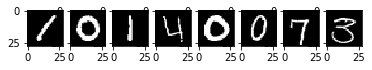

In [6]:
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(train_df.iloc[i, 1:].values.reshape(28, 28), cmap='gray')
    print(train_df.iloc[i, 0])

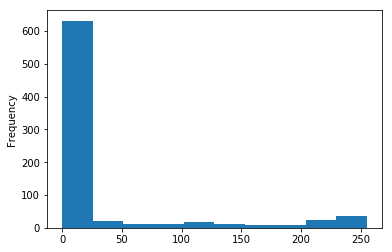

In [7]:
train_df.iloc[i, 1:].plot(kind='hist')

The value of each pixel is 0~255, we'd better normalize it(devided by 255). `torch.utils.data.Dataset` is a convenient tools for data loading provided by PyTorch.

It is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that dataset[i] can be used to get ith sample

In [0]:
class MNIST_dataset(Dataset):
    def __init__(self, df, rows=42000):
        self.imgnp = df.iloc[:rows, 1:].values
        self.labels = df.iloc[:rows, 0].values
        self.rows = rows
    
    def __len__(self):
        return self.rows
    
    def __getitem__(self, idx):
        image = torch.tensor(self.imgnp[idx], dtype=torch.float) / 255  # Normalize
        image = image.view(1, 28, 28)  # (channel, height, width)
        label = self.labels[idx]
        return (image, label)

In [0]:
trainloader = DataLoader(MNIST_dataset(train_df, 42000), batch_size=4, shuffle=True)

In [0]:
dataiter = iter(trainloader)

In [0]:
images, labels = dataiter.next()

In [12]:
images.size(), labels.size()

(torch.Size([4, 1, 28, 28]), torch.Size([4]))

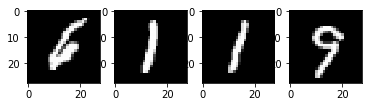

In [13]:
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i, 0], cmap='gray')

In [14]:
labels

tensor([6, 1, 1, 9])

## 2. Define a Convolution Neural Network

Our CNN model is as follow
![CNN model](https://pytorch.org/tutorials/_images/mnist.png)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
 # Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

'Tesla T4'

In [0]:
net = Net().to(device)

## 3. Loss Function

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) 

lr(learning rate) is a very important hyperparameter. Small lr will make the traning process very slow, but increase lr may also cause overshooting the global optimum and cause divergent. A good method is plot the Learning rate curve.

## 4. Train the network on the training data

In [21]:
running_loss_list = []
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 800 == 799:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 800)
                 )
            running_loss_list.append(running_loss)
            running_loss = 0.0
print('Finished Training')

[1,   800] loss: 1.169
[1,  1600] loss: 0.402
[1,  2400] loss: 0.319
[1,  3200] loss: 0.301
[1,  4000] loss: 0.310
[1,  4800] loss: 0.225
[1,  5600] loss: 0.283
[1,  6400] loss: 0.289
[1,  7200] loss: 0.261
[1,  8000] loss: 0.309
[1,  8800] loss: 0.258
[1,  9600] loss: 0.259
[1, 10400] loss: 0.199
[2,   800] loss: 0.225
[2,  1600] loss: 0.225
[2,  2400] loss: 0.255
[2,  3200] loss: 0.241
[2,  4000] loss: 0.195
[2,  4800] loss: 0.212
[2,  5600] loss: 0.273
[2,  6400] loss: 0.210
[2,  7200] loss: 0.381
[2,  8000] loss: 0.364
[2,  8800] loss: 0.431
[2,  9600] loss: 0.376
[2, 10400] loss: 0.406
Finished Training


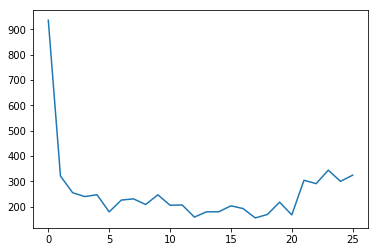

In [22]:
plt.plot(running_loss_list)

The Learning rate curve is divergent, which means the learning rate is to large, we should decrease it.

In [23]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

running_loss_list = []
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 200)
                 )
            running_loss_list.append(running_loss)
            running_loss = 0.0
print('Finished Training')

[1,   200] loss: 2.304
[1,   400] loss: 2.301
[1,   600] loss: 2.296
[1,   800] loss: 2.285
[1,  1000] loss: 2.269
[1,  1200] loss: 2.174
[1,  1400] loss: 1.600
[1,  1600] loss: 1.015
[1,  1800] loss: 0.693
[1,  2000] loss: 0.570
[1,  2200] loss: 0.504
[1,  2400] loss: 0.448
[1,  2600] loss: 0.317
[1,  2800] loss: 0.302
[1,  3000] loss: 0.372
[1,  3200] loss: 0.284
[1,  3400] loss: 0.252
[1,  3600] loss: 0.288
[1,  3800] loss: 0.235
[1,  4000] loss: 0.232
[1,  4200] loss: 0.208
[1,  4400] loss: 0.195
[1,  4600] loss: 0.205
[1,  4800] loss: 0.157
[1,  5000] loss: 0.145
[1,  5200] loss: 0.155
[1,  5400] loss: 0.188
[1,  5600] loss: 0.189
[1,  5800] loss: 0.143
[1,  6000] loss: 0.175
[1,  6200] loss: 0.131
[1,  6400] loss: 0.154
[1,  6600] loss: 0.121
[1,  6800] loss: 0.126
[1,  7000] loss: 0.124
[1,  7200] loss: 0.146
[1,  7400] loss: 0.136
[1,  7600] loss: 0.136
[1,  7800] loss: 0.100
[1,  8000] loss: 0.131
[1,  8200] loss: 0.124
[1,  8400] loss: 0.107
[1,  8600] loss: 0.157
[1,  8800] 

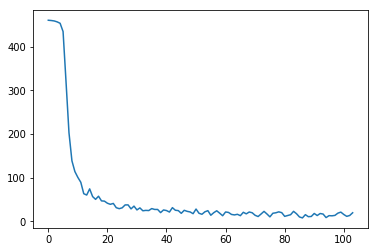

In [24]:
plt.plot(running_loss_list)

I't better, we will take this model as our final one.

## 5. Evaluate the model

In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on train images: ', correct/total)

Accuracy of the network on train images:  0.9820476190476191


We achieve 98% accuracy on training data. It's not bad!

## 6. Prediction and Submition

In [0]:
test_df = pd.read_csv('/content/drive/My Drive/DataSets/Mnist_Digit/test.csv')

In [29]:
test_df.values.shape

(28000, 784)

In [0]:
test_tensor = torch.tensor(test_df.values, dtype=torch.float) / 255
test_tensor = test_tensor.view(-1, 1, 28, 28).to(device)
#test_tensor.to(device)

In [0]:
outputs = net(test_tensor).to(device)

In [0]:
_, predicted = torch.max(outputs, 1)
#predicted.to('cpu')

In [0]:
submit_df = pd.DataFrame({'ImageId': np.arange(1, 28001), 'Label': predicted.cpu().numpy()})

In [0]:
submit_df.to_csv('cnn.csv', index=False)

### That's all, thank's for advice!